# Predicting the NBA MVP with Machine Learning

The goal of this analysis is to predict the NBA MVP for a given year, based on NBA player data and MVP voting data in other years. This is accomplished by applying several machine learning regressioin algorithms on NBA player performance data. The analysis is based on the [Scikit-learn](http://scikit-learn.org) machine learning package, NBA player data are taken from [basketball-reference.com](https://www.basketball-reference.com).

## Import modules and libraries:

In [1]:
import NBAanalysissetup # See NBAanalysissetup.py

from NBAanalysissetup import MyModel, MyCM

import matplotlib.pyplot as plt
import numpy             as np
import pandas            as pd
import seaborn           as sns

import copy
import operator
import sys
import time

from IPython.display import display, HTML

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from sklearn.decomposition import PCA

from sklearn.neighbors        import KNeighborsRegressor
from sklearn.linear_model     import Ridge, Lasso, ElasticNet, SGDRegressor, PassiveAggressiveRegressor
from sklearn.linear_model     import RidgeCV, LassoCV, ElasticNetCV
from sklearn.svm              import SVR # LinearSVR, NuSVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.tree             import DecisionTreeRegressor
from sklearn.ensemble         import RandomForestRegressor, ExtraTreesRegressor 
from sklearn.ensemble         import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neural_network   import MLPRegressor

from xgboost                  import XGBRegressor

from sklearn.model_selection import validation_curve, LeaveOneGroupOut, GridSearchCV

from sklearn.metrics import explained_variance_score, median_absolute_error, mean_absolute_error 
from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
start = time.time()

## User input

Choose the year you want to predict, between 2010 and 2018. The years that are not selected are used for cross-validation and training of the ML algorithms.

In [3]:
test_year = 2018 # Enter any year from 2010 until 2018

print("--> Test year = {}".format(test_year))

first_year = 2000 # First year for which data has been scraped
last_year  = 2018 # Last  year for which data has been scraped

train_years = list(range(first_year, last_year+1))

train_years.remove(test_year)

first_train_year = train_years[0]
last_train_year  = train_years[-1]
    
if (first_train_year < test_year < last_train_year):
    print("--> Train years = {}-{} except {}".format(first_train_year, last_train_year, test_year))
else:
    print("--> Train years = {}-{}".format(first_train_year, last_train_year))

--> Test year = 2018
--> Train years = 2000-2017


Choose whether you want to include advanced players statistics (e.g. *PER*, *VORP*, etc.) in the model or not,
and choose the minimum number of games a player has to have played per season to be included in the analysis:

In [4]:
includeadvancedstats = True # Enter True or False

if includeadvancedstats:
    print("--> Advanced statistics included")
else:
    print("--> Advanced statistics not included")
    
min_num_games = 60 # Enter any number between 0 and 82

print("--> Minimum number of games for each player =", min_num_games)

--> Advanced statistics included
--> Minimum number of games for each player = 60


## NBA player data

NBA player data from 2010-2018 from [basketball-reference.com](https://www.basketball-reference.com) have been saved as csv-files in the **data** directory using the scraper functions in [NBAanalysissetup.py](NBAanalysissetup.py).

In [5]:
df_train, df_test = NBAanalysissetup.loaddata_allyears(train_years, test_year, includeadvancedstats, target='MVP')

--> Loading train year 1999-2000 ...
--> Loading train year 2000-2001 ...
--> Loading train year 2001-2002 ...
--> Loading train year 2002-2003 ...
--> Loading train year 2003-2004 ...
--> Loading train year 2004-2005 ...
--> Loading train year 2005-2006 ...
--> Loading train year 2006-2007 ...
--> Loading train year 2007-2008 ...
--> Loading train year 2008-2009 ...
--> Loading train year 2009-2010 ...
--> Loading train year 2010-2011 ...
--> Loading train year 2011-2012 ...
--> Loading train year 2012-2013 ...
--> Loading train year 2013-2014 ...
--> Loading train year 2014-2015 ...
--> Loading train year 2015-2016 ...
--> Loading train year 2016-2017 ...
--> Loading test  year 2017-2018 ...


Print table of players with MVP votes in *test_year*:

Select only players which have played at least *min_num_games* number of games started in a season:

In [6]:
print("--> # of players in train set =", df_train.shape[0])
print("--> # of players in test  set =", df_test .shape[0])
print("")

df_train = df_train[df_train['GS'] >= min_num_games]
df_test  = df_test [df_test ['GS'] >= min_num_games]

print("--> # of players in train set =", df_train.shape[0])
print("--> # of players in test  set =", df_test .shape[0])

#df_train = df_train[df_train['MVS'] > 0]
#df_test  = df_test [df_test ['MVS'] > 0]

#print("--> # of players in train set =", df_train.shape[0])
#print("--> # of players in test  set =", df_test .shape[0])

# Reset dataframe indices:

df_train = df_train.reset_index(drop=True)
df_test  = df_test .reset_index(drop=True)

--> # of players in train set = 8240
--> # of players in test  set = 540

--> # of players in train set = 1793
--> # of players in test  set = 96


NaN handling:

In [7]:
print("--> # of players with NaNs in train set =", df_train.shape[0] - df_train.dropna().shape[0])
print("--> # of players with NaNs in test  set =", df_test .shape[0] - df_test .dropna().shape[0])
print("")

# Replace NaNs with 0s in the following columns:

df_train[['FG%', '3P%', '2P%', 'FT%', 'eFG%']] = df_train[['FG%', '3P%', '2P%', 'FT%', 'eFG%']].fillna(value=0)
df_test [['FG%', '3P%', '2P%', 'FT%', 'eFG%']] = df_test [['FG%', '3P%', '2P%', 'FT%', 'eFG%']].fillna(value=0)

if (includeadvancedstats):
    df_train[['TS%', '3PAr', 'FTr']] = df_train[['TS%', '3PAr', 'FTr']].fillna(value=0)
    df_test [['TS%', '3PAr', 'FTr']] = df_test [['TS%', '3PAr', 'FTr']].fillna(value=0)
    
print("--> # of players with NaNs in train set =", df_train.shape[0] - df_train.dropna().shape[0])
print("--> # of players with NaNs in test  set =", df_test .shape[0] - df_test .dropna().shape[0])
print("")

# Remove remaining players with NaNs, if necessary:

if (df_train.shape[0] - df_train.dropna().shape[0] != 0):
    #print("--> Players in train set with NaNs:")
    #print(df_train[df_train.isnull().any(axis=1)])
    #print("")
    df_train.dropna(inplace=True)
    print("--> # of players with NaNs in train set =", df_train.shape[0] - df_train.dropna().shape[0])

if (df_test.shape[0] - df_test.dropna().shape[0] != 0):
    #print("--> Players in test set with NaNs:")
    #print(df_test[df_test.isnull().any(axis=1)])
    #print("")
    df_test.dropna(inplace=True)
    print("--> # of players with NaNs in test  set =", df_test.shape[0] - df_test.dropna().shape[0])
    
# Reset dataframe indices:

df_train = df_train.reset_index(drop=True)
df_test  = df_test .reset_index(drop=True)

--> # of players with NaNs in train set = 97
--> # of players with NaNs in test  set = 2

--> # of players with NaNs in train set = 0
--> # of players with NaNs in test  set = 0



Prepare data and create features (*X*) and target (*y*) dataframes needed for Scikit-learn methods:

In [8]:
# Features dataframes (MVS and YEAR are dropped: MVS is the target variable, YEAR is only used for cross-validation):

X_train = df_train.drop(['MVS', 'YEAR'], axis=1)
X_test  = df_test .drop(['MVS', 'YEAR'], axis=1)

X_list = [X_train, X_test]

for X in X_list:
    
    # Remove features:

    X.drop(['Player', 'Pos', 'Tm', 'Age', 'TC',                             # No predictive power
            'FG', 'FGA', 'FG%', '3P%', '2P%', 'FT%', 'eFG%', 'TRB', 'PTS'], # Correlated with other features
           axis=1, inplace=True)

    if includeadvancedstats:
        X.drop(['TS%', '3PAr', 'FTr', 'TRB%', 'WS', 'WS/48', 'BPM',         # Correlated with other features 
                'ORB', 'DRB', 'AST', 'TOV', 'STL', 'BLK'],                  # Correlated with other features
               axis=1, inplace=True) 
    
    # Replace GS by GS/G, and MP by MP/G:

    X['GS'] = X['GS'].div(X['G'].values, axis=0).round(2)
    X['MP'] = X['MP'].div(X['G'].values, axis=0).round(1)
    X['TW'] = X['TW'].div(82, axis=0)           .round(2)
    X.rename(columns={'GS': 'GS/G', 'MP': 'MP/G', 'TW': 'TW/82'}, inplace=True)
    
    '''
    # Scale total-type features by MP/48:

    X[['3P', '3PA', '2P', '2PA', 'FT', 'FTA', 'PF']] = \
    X[['3P', '3PA', '2P', '2PA', 'FT', 'FTA', 'PF']].div(X['MP/48'].values, axis=0)
    X.rename(columns={'3P': '3P/48', '3PA': '3PA/48', 'FT': 'FT/48', 'FTA': 'FTA/48', 
                      '2P': '2P/48', '2PA': '2PA/48', 'PF': 'PF/48'}, inplace=True)
    
    if includeadvancedstats:
        X[['OWS', 'DWS']] = \
        X[['OWS', 'DWS']].div(X['MP/48'].values, axis=0)
        X.rename(columns={'OWS': 'OWS/48', 'DWS': 'DWS/48'}, inplace=True)
    else:
        X[['ORB', 'DRB', 'AST', 'STL', 'BLK', 'TOV', 'PF']] = \
        X[['ORB', 'DRB', 'AST', 'STL', 'BLK', 'TOV', 'PF']].div(X['MP/48'].values, axis=0)
        X.rename(columns={'ORB': 'ORB/48', 'DRB': 'DRB/48', 'AST': 'AST/48', 'PF': 'PF/48',
                          'BLK': 'BLK/48', 'TOV': 'TOV/48', 'STL': 'STL/48'}, inplace=True)
    '''
    
# Target dataframes (target = MVS, a floating variable introduced to indicate players' MVP vote share):

y_train = df_train['MVS']
y_test  = df_test ['MVS']

n_players_train = X_train.shape[0]
n_players_test  = X_test .shape[0]
n_features = X_test.shape[1] # equals X_train.shape[1]

print("--> Train data set : # of players = {:4}, # of features = {}".format(n_players_train, n_features))
print("--> Test  data set : # of players = {:4}, # of features = {}".format(n_players_test,  n_features))
print("")

print("--> Model features : ", list(X_train.columns))

--> Train data set : # of players = 1793, # of features = 24
--> Test  data set : # of players =   96, # of features = 24

--> Model features :  ['G', 'GS/G', 'MP/G', '3P', '3PA', '2P', '2PA', 'FT', 'FTA', 'PF', 'PER', 'ORB%', 'DRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'OBPM', 'DBPM', 'VORP', 'TW/82']


Explore relationship between MVS and other features in training data:

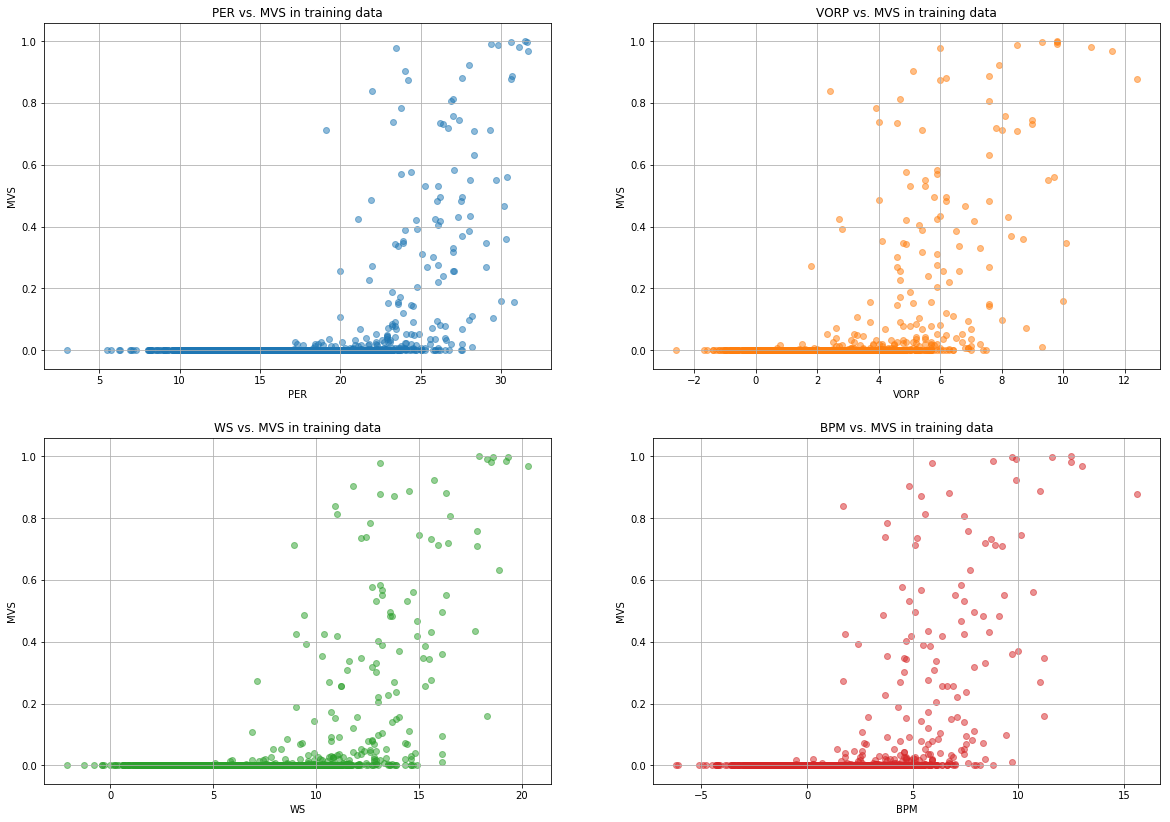

In [9]:
color=iter(plt.cm.tab20(np.linspace(0, 1, 10)))    

if includeadvancedstats:
    plotfeatures = ['PER', 'VORP', 'WS', 'BPM']
else:
    plotfeatures = ['PTS', 'eFG%', 'MP']

plt.figure(figsize=(20, 14))

for ifeature, feature in enumerate(plotfeatures):

    plt.subplot(2, 2, ifeature+1)

    plt.title("{} vs. MVS in training data".format(feature))
    plt.xlabel(feature)
    plt.ylabel('MVS')
    plt.scatter(df_train[feature], df_train['MVS'], color=next(color), alpha=0.5)
    #plt.xlim(-0.05, 1.05)
    #plt.ylim(-0.05, 1.05)
    plt.grid(True)

Scale feature dataframes to accommodate ML algorithms:

In [10]:
feature_names = X_train.columns # This is no longer available after transformation with scaler

#X_scaler = StandardScaler(with_mean=True, with_std=True) # Scaler with zero mean and unit variance
#X_scaler = MinMaxScaler() # Scales features to range 0 to 1 (or -1 to 1 if there are negative values)
X_scaler = RobustScaler() # Similar method to the MinMaxScaler but more robust to outliers

X_train = X_scaler.fit_transform(X_train) # Fit scaler to training data and transform X_train
X_test  = X_scaler.transform(X_test)      # Transform X_test using fitted scaler

## Supervised Learning: Regression

Select ML regressors, set hyper-parameters and instantiate models:

In [11]:
rseed = 666 # Set random_state of model (where applicable) to specific seed, to tune hyper-parameters

models = []

estimator_name = 'Nearest Neighbours Regressor'
n_n = 10
w   = 'uniform' # 'uniform', 'distance'
estimator = KNeighborsRegressor(n_neighbors=n_n, weights=w)
models.append(MyModel(estimator_name, estimator))

'''
estimator_name = 'Ridge Regressor' # Shrinkage => Feature coefficient suppression
a = 0.1 # regularization factor (higher alpha -> stronger regularization i.e. opposite of C parameter)
estimator = Ridge(alpha=a, random_state=rseed)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'Lasso Regressor' # Sparsity => Feature selection
a = 1e-05
estimator = Lasso(alpha=a, random_state=rseed)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'ElasticNet Regressor' # Shrinkage & Sparsity
a = 1e-04
l_r = 0.5
estimator = ElasticNet(alpha=a, l1_ratio=l_r, random_state=rseed)
models.append(MyModel(estimator_name, estimator))
'''

estimator_name = 'Support Vector Machine Regressor'
#estimator_name = 'Linear Support Vector Machine Regressor'
C = 0.1
e = 0.1
k = 'poly' # 'linear'
d = 3 # only used by poly kernel
estimator = SVR(C=C, epsilon=e, kernel=k, degree=d, cache_size=1000)
#l = 'epsilon_insensitive' # i.e. l1 regularizarion -> Sparsity
#l = 'squared_epsilon_insensitive' # i.e. l2 regularizarion -> Shrinkage 
#estimator = LinearSVR(C=C, loss=l, dual=False, random_state=rseed)
models.append(MyModel(estimator_name, estimator))

'''
estimator_name = 'Stochastic Gradient Descent Regressor'
#l = 'hinge' # 'log', 'modified_huber', 'squared_hinge', 'perceptron'
#p = 'l2'
estimator = SGDRegressor(random_state=rseed) #(loss=l, penalty=p, random_state=rseed)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'Passive Aggressive Regressor'
#C = 0.001
#l = 'squared_hinge' # 'hinge'
estimator = PassiveAggressiveRegressor(random_state=rseed) #(C=C, loss=l, random_state=rseed)
models.append(MyModel(estimator_name, estimator))
'''

estimator_name = 'Neural Network Regressor'
a = 1.0 # l2 regularization factor
estimator = MLPRegressor(alpha=a, random_state=rseed)
models.append(MyModel(estimator_name, estimator))

'''
estimator_name = 'Gaussian Process Regressor' # (CV is slowwwwwwww)
estimator = GaussianProcessRegressor(random_state=rseed)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'Decision Tree Regressor'
m_d = None   # i.e. nodes are expanded until leafs are pure 
m_f = 'auto' # The number of features to consider when looking for the best split. 
#              'auto' => max_features=sqrt(n_features) 
estimator = DecisionTreeRegressor(random_state=rseed) #(max_depth=m_d, max_features=m_f, class_weight='balanced', random_state=rseed)
models.append(MyModel(estimator_name, estimator))
'''

estimator_name = 'Random Forest Regressor'
n_e = 200
m_d = None
m_f = 'auto'
estimator = RandomForestRegressor(n_estimators=n_e, max_depth=m_d, max_features=m_f, random_state=rseed)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'Extra Randomized Trees Regressor'
n_e = 200
m_d = None
m_f = 'auto'
estimator = ExtraTreesRegressor(n_estimators=n_e, max_depth=m_d, max_features=m_f, random_state=rseed)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'Gradient Boosted Decision Tree Regressor'
n_e = 200
m_d = 3
l_r = 0.1
estimator = GradientBoostingRegressor(n_estimators=n_e, max_depth=m_d, learning_rate=l_r, random_state=rseed)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'Adaptive Boosted Decision Tree Regressor'
n_e = 200
l_r = 0.1
estimator = AdaBoostRegressor(n_estimators=n_e, learning_rate=l_r, random_state=rseed)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'Extreme Gradient Boosted Decision Tree Regressor'
n_e = 200
m_d = 3
l_r = 0.1
estimator = XGBRegressor(n_estimators=n_e, max_depth=m_d, learning_rate=l_r, random_state=rseed)
models.append(MyModel(estimator_name, estimator))

print("--> ML regressors implemented in this analysis:")
print("")

modelnames = []

for counter, model in enumerate(models, 0):
    print("{:2} : {}".format(counter, model.estimator_name))
    #print("     Model parameters : ", mymodel.estimator.get_params())
    modelnames.append(model.estimator_name)

--> ML regressors implemented in this analysis:

 0 : Nearest Neighbours Regressor
 1 : Support Vector Machine Regressor
 2 : Neural Network Regressor
 3 : Random Forest Regressor
 4 : Extra Randomized Trees Regressor
 5 : Gradient Boosted Decision Tree Regressor
 6 : Adaptive Boosted Decision Tree Regressor
 7 : Extreme Gradient Boosted Decision Tree Regressor


## Cross-validation

Cross-validate the model using training data and the *LeaveOneGroupOut* cross-validation scheme in which a group is defined as a single NBA season.

Use *GridSearchCV* to tune hyperparameters:

Plot validation curves to tune hyperparameters:

Calculate some regression scores:

In [12]:
X_train = np.array(X_train) # To accommodate X_train = X_training[train_index] and X_test = X_training[test_index]
y_train = np.array(y_train) # To accommodate y_train = y_training[train_index] and y_test = y_training[test_index]

logo = LeaveOneGroupOut()

cv_groups = df_train['YEAR'] # Players in the same group (i.e. a single NBA season) have identical YEAR variables

cv_scores = []

for imodel, model in enumerate(models):
    
    #if (imodel != 0):
    #    continue
    
    model.reset()
    
    regressor      = model.estimator
    regressor_name = model.estimator_name

    model.YEAR_cvgroups = train_years
    
    EVS_cvgroups   = []
    MEDAE_cvgroups = []
    MAE_cvgroups   = []
    MSE_cvgroups   = []
    MSLE_cvgroups  = []
    R2S_cvgroups   = []

    print("--> Cross-validating", regressor_name, "...")
    
    for train_index, test_index in logo.split(X_train, y_train, groups=cv_groups):

        X_cvtrain = X_train[train_index]
        X_cvtest  = X_train[test_index]
        y_cvtrain = y_train[train_index]
        y_cvtest  = y_train[test_index]
                       
        regressor.fit(X_cvtrain, y_cvtrain)
    
        y_cvprediction = regressor.predict(X_cvtest) 
        y_cvtruth      = y_cvtest.tolist()
                
        regressor.fit(X_train, y_train)          # Fit model to training data

        EVS_cvgroups  .append(explained_variance_score(y_cvtruth, y_cvprediction))
        MEDAE_cvgroups.append(median_absolute_error   (y_cvtruth, y_cvprediction))
        MAE_cvgroups  .append(mean_absolute_error     (y_cvtruth, y_cvprediction))
        MSE_cvgroups  .append(mean_squared_error      (y_cvtruth, y_cvprediction))
        MSLE_cvgroups .append(mean_squared_log_error  (y_cvtruth, y_cvprediction))
        R2S_cvgroups  .append(r2_score                (y_cvtruth, y_cvprediction))
        
    cv_scores.append({'Estimator'  : regressor_name, 
                      'EVS mean'   : (np.mean(EVS_cvgroups)  *1).round(3),
                      'EVS std'    : (np.std (EVS_cvgroups)  *1).round(3),
                      'MedAE mean' : (np.mean(MEDAE_cvgroups)*1).round(3),
                      'MedAE std'  : (np.std (MEDAE_cvgroups)*1).round(3),
                      'MAE mean'   : (np.mean(MAE_cvgroups)  *1).round(3),
                      'MAE std'    : (np.std (MAE_cvgroups)  *1).round(3),
                      'MSE mean'   : (np.mean(MSE_cvgroups)  *1).round(3),
                      'MSE std'    : (np.std (MSE_cvgroups)  *1).round(3),
                      'MSLE mean'  : (np.mean(MSLE_cvgroups) *1).round(3),
                      'MSLE std'   : (np.std (MSLE_cvgroups) *1).round(3),
                      'R2S mean'   : (np.mean(R2S_cvgroups)  *1).round(3),
                      'R2S std'    : (np.std (R2S_cvgroups)  *1).round(3)})
    
print("")
print("--> Regression scores for all models (mean and std over all years):")
print("")

columnorder = ['Estimator', 'EVS mean', 'EVS std', 'MedAE mean', 'MedAE std', 'MAE mean', 'MAE std', 
               'MSE mean', 'MSE std', 'MSLE mean', 'MSLE std', 'R2S mean', 'R2S std']

df_cv_scores = pd.DataFrame(cv_scores, columns=columnorder)

display(HTML(df_cv_scores.to_html()))

--> Cross-validating Nearest Neighbours Regressor ...
--> Cross-validating Support Vector Machine Regressor ...
--> Cross-validating Neural Network Regressor ...
--> Cross-validating Random Forest Regressor ...
--> Cross-validating Extra Randomized Trees Regressor ...
--> Cross-validating Gradient Boosted Decision Tree Regressor ...
--> Cross-validating Adaptive Boosted Decision Tree Regressor ...
--> Cross-validating Extreme Gradient Boosted Decision Tree Regressor ...

--> Regression scores for all models (mean and std over all years):



,Estimator,EVS mean,EVS std,MedAE mean,MedAE std,MAE mean,MAE std,MSE mean,MSE std,MSLE mean,MSLE std,R2S mean,R2S std
0,Nearest Neighbours Regressor,0.564,0.157,0.000,0.000,0.021,0.005,0.007,0.003,0.004,0.001,0.561,0.158
1,Support Vector Machine Regressor,0.619,0.176,0.010,0.003,0.031,0.007,0.006,0.003,0.003,0.002,0.615,0.177
2,Neural Network Regressor,0.621,0.169,0.009,0.001,0.028,0.006,0.006,0.003,0.003,0.002,0.616,0.170
3,Random Forest Regressor,0.578,0.222,0.000,0.000,0.021,0.007,0.007,0.004,0.004,0.002,0.572,0.226
4,Extra Randomized Trees Regressor,0.624,0.189,0.000,0.000,0.021,0.007,0.006,0.003,0.003,0.002,0.619,0.193
5,Gradient Boosted Decision Tree Regressor,0.591,0.228,0.001,0.000,0.022,0.007,0.006,0.004,0.004,0.002,0.585,0.231
6,Adaptive Boosted Decision Tree Regressor,0.573,0.220,0.012,0.005,0.035,0.011,0.007,0.004,0.004,0.002,0.550,0.236
7,Extreme Gradient Boosted Decision Tree Regressor,0.593,0.219,0.001,0.000,0.023,0.007,0.006,0.004,0.004,0.002,0.588,0.222


#### Conclusion: 

The cross-validation metrics indicate that all models work reasonably well.

In [13]:
rejected_models = []

## Model training and predictions

Fit all models to training data and use fitted models to predict the players' MVP voting share in *test_year*:

In [14]:
scores_list = []

for model in models:
    
    regressor = model.estimator

    print("--> Fitting", model.estimator_name, "...")
    
    regressor.fit(X_train, y_train)          # Fit model to training data

    y_prediction = regressor.predict(X_test) # Predict test data
    model.set_y_prediction(y_prediction)
    
    '''
    y_truth = y_test.tolist()
    model.set_y_truth(y_truth)
    
    regression_scores = {}
    
    regression_scores['explained_variance_score'] = explained_variance_score(y_truth, y_prediction)
    regression_scores['median_absolute_error'   ] = median_absolute_error(y_truth, y_prediction)
    regression_scores['mean_absolute_error'     ] = mean_absolute_error(y_truth, y_prediction)
    regression_scores['mean_squared_error'      ] = mean_squared_error(y_truth, y_prediction)
    regression_scores['mean_squared_log_error'  ] = mean_squared_log_error(y_truth, y_prediction)
    regression_scores['r2_score'                ] = r2_score(y_truth, y_prediction)
    
    print("--> regression scores:", regression_scores)
    
    model.set_regression_scores(regression_scores)
    '''
    
    y_score = regressor.score(X_test, y_test) # i.e. r2 score
    model.set_y_score(y_score)

--> Fitting Nearest Neighbours Regressor ...
--> Fitting Support Vector Machine Regressor ...
--> Fitting Neural Network Regressor ...
--> Fitting Random Forest Regressor ...
--> Fitting Extra Randomized Trees Regressor ...
--> Fitting Gradient Boosted Decision Tree Regressor ...
--> Fitting Adaptive Boosted Decision Tree Regressor ...
--> Fitting Extreme Gradient Boosted Decision Tree Regressor ...


Calculate feature importances of all fitted Decision Tree ensemble models (e.g. Random Forest):

In [15]:
df_importances = pd.DataFrame(columns=modelnames, index=feature_names)

for model in models:

    print("--> Calculating feature importances for", model.estimator_name, "...")
    
    if hasattr(model.estimator, "feature_importances_"):
    
        importances = model.estimator.feature_importances_
            
        for i in range(n_features):
            df_importances.loc[feature_names[i], model.estimator_name] = (importances[i]*100).round(1)
        
print("")
print("--> Feature importances of all models:")
print("")

display(HTML(df_importances.to_html()))

--> Calculating feature importances for Nearest Neighbours Regressor ...
--> Calculating feature importances for Support Vector Machine Regressor ...
--> Calculating feature importances for Neural Network Regressor ...
--> Calculating feature importances for Random Forest Regressor ...
--> Calculating feature importances for Extra Randomized Trees Regressor ...
--> Calculating feature importances for Gradient Boosted Decision Tree Regressor ...
--> Calculating feature importances for Adaptive Boosted Decision Tree Regressor ...
--> Calculating feature importances for Extreme Gradient Boosted Decision Tree Regressor ...

--> Feature importances of all models:



,Nearest Neighbours Regressor,Support Vector Machine Regressor,Neural Network Regressor,Random Forest Regressor,Extra Randomized Trees Regressor,Gradient Boosted Decision Tree Regressor,Adaptive Boosted Decision Tree Regressor,Extreme Gradient Boosted Decision Tree Regressor
G,NaN,NaN,NaN,1.1,2.1,2.3,0.7,5.5
GS/G,NaN,NaN,NaN,0.1,0.3,0,0,0
MP/G,NaN,NaN,NaN,1.2,1.3,2.5,1.9,5.5
3P,NaN,NaN,NaN,1,1.4,1.5,0.6,3.6
3PA,NaN,NaN,NaN,0.7,1.4,2.6,0.4,1.7
2P,NaN,NaN,NaN,1.1,2.4,3.1,1.3,4.5
2PA,NaN,NaN,NaN,1.7,1.7,4.2,1.8,4.3
FT,NaN,NaN,NaN,1.1,1.7,4.2,0.6,2.5
FTA,NaN,NaN,NaN,1.6,2.9,4.9,3.3,3.4
PF,NaN,NaN,NaN,1.7,1.8,7.7,2.7,5.2


## Final prediction

Calculate prediction scores for all models, and add scores and corresponding ranks to the *test* dataframe:

In [16]:
player_index_dict = {}
for i in range(n_players_test):
    player_name = df_test.iat[i,0]
    player_index_dict[player_name] = i

for imodel, model in enumerate(models):
        
    column_name_score      = 'CLF{}_score'     .format(imodel)
    column_name_rank       = 'CLF{}_rank'      .format(imodel)
    df_rank = pd.DataFrame(columns=['Player', column_name_rank], index=range(0,n_players_test))

    regressor    = model.estimator
    y_prediction = model.y_prediction
    
    df_test[column_name_score] = y_prediction # R2 score
    
    player_score_dict = {}
    for i in range(n_players_test):
        player_score_dict[df_test.iat[i,0]] = y_prediction[i]

    sorted_player_score_dict = sorted(player_score_dict.items(), key=operator.itemgetter(1), reverse=True)
    
    printlimit = 10
    
    print("==> MVP vote shares for top-{} players in {} according to {}:".format(printlimit, test_year, model.estimator_name))
    print("")
    
    previous_rank  = 0
    previous_score = 1e10
    rank_increment = 0
    
    for i, (key, value) in enumerate(dict(sorted_player_score_dict).items(), 1):
        
        if (value < previous_score):
            rank = previous_rank + 1 + rank_increment
            rank_increment = 0
        else:
            rank = previous_rank
            rank_increment += 1
        previous_rank  = rank
        previous_score = value
        
        df_rank.loc[player_index_dict[key], 'Player'        ] = key
        df_rank.loc[player_index_dict[key], column_name_rank] = rank
        
        if (i <= printlimit):
            print("----> {:3}: {:24} = {:6.3f}".format(rank, key, value))
            
    df_test = pd.merge(df_test, df_rank, how='right', left_on=['Player'], right_on=['Player'])    
    print("")

==> MVP vote shares for top-10 players in 2018 according to Nearest Neighbours Regressor:

---->   1: James Harden             =  0.563
---->   2: LeBron James             =  0.428
---->   3: Russell Westbrook        =  0.220
---->   4: Kevin Durant             =  0.146
---->   5: Anthony Davis            =  0.142
---->   6: Giannis Antetokounmpo    =  0.120
---->   7: DeMar DeRozan            =  0.109
---->   8: Damian Lillard           =  0.081
---->   9: Ben Simmons              =  0.027
---->  10: Andre Drummond           =  0.026

==> MVP vote shares for top-10 players in 2018 according to Support Vector Machine Regressor:

---->   1: James Harden             =  0.722
---->   2: LeBron James             =  0.539
---->   3: Russell Westbrook        =  0.258
---->   4: Anthony Davis            =  0.240
---->   5: Damian Lillard           =  0.190
---->   6: Kevin Durant             =  0.149
---->   7: Giannis Antetokounmpo    =  0.141
---->   8: Andre Drummond           =  0.103
---

Create MVP candidate list with all scores and scoring ranks, sorted according to the mean rank / median score over all models:

In [17]:
score_column_names = []
rank_column_names  = []
both_column_names  = []

for imodel in range(len(models)):
    
    if imodel in rejected_models:
        continue
        
    score_column_names.append("CLF{:d}_score".format(imodel))
    rank_column_names .append("CLF{:d}_rank" .format(imodel))
    both_column_names .append("CLF{:d}_score".format(imodel))
    both_column_names .append("CLF{:d}_rank" .format(imodel))

all_column_names = ['Player', 'Tm', 'G']
all_column_names.extend(both_column_names)

df_mvp = df_test.filter(all_column_names, axis=1)

'''
# Scale all score-ranks between 1 and n_players_test:

scaler = MinMaxScaler(feature_range=(1,n_players_test))

df_mvp[rank_column_names] = scaler.fit_transform(df_mvp[rank_column_names])
'''

# Calculate median R2 score and mean scoring rank of all non-rejected models:

df_test['Median model score'] = df_mvp[score_column_names].median(axis=1)
df_test['Mean model rank' ]   = df_mvp[rank_column_names ].mean  (axis=1)

df_mvp['Median model score'] = df_mvp[score_column_names].median(axis=1)
df_mvp['Mean model rank' ]   = df_mvp[rank_column_names ].mean  (axis=1)

df_mvp['MVS'] = df_test['MVS']

#df_mvp = df_mvp.sort_values('Median model score', ascending=False)
df_mvp = df_mvp.sort_values('Mean model rank',  ascending=True)

df_mvp = df_mvp.reset_index(drop=True)

df_mvp.index = np.arange(1, len(df_mvp) + 1)

print_limit = 10

print("--> Top-{} NBA players according to the mean predicted MVS rank amongst all models:".format(print_limit))
#print("--> Top-{} NBA players according to the median predicted MVS score amongst all models:".format(print_limit))
print("")

display(HTML(df_mvp[:print_limit].to_html()))

--> Top-10 NBA players according to the mean predicted MVS rank amongst all models:



,Player,Tm,G,CLF0_score,CLF0_rank,CLF1_score,CLF1_rank,CLF2_score,CLF2_rank,CLF3_score,CLF3_rank,CLF4_score,CLF4_rank,CLF5_score,CLF5_rank,CLF6_score,CLF6_rank,CLF7_score,CLF7_rank,Median model score,Mean model rank,MVS
1,James Harden,HOU,72,0.5625,1,0.721750,1,0.591497,1,0.780600,1,0.766670,1,0.938876,1,0.600244,1,0.921279,1,0.744210,1.000,0
2,LeBron James,CLE,82,0.4283,2,0.539148,2,0.497976,2,0.452940,2,0.434010,2,0.572025,2,0.483848,2,0.413266,2,0.468394,2.000,0
3,Russell Westbrook,OKC,80,0.2204,3,0.258419,3,0.285551,3,0.268720,3,0.221700,4,0.095479,8,0.323910,3,0.127369,7,0.240060,4.250,0
4,Kevin Durant,GSW,68,0.1456,4,0.148612,6,0.240171,5,0.232575,5,0.249695,3,0.291686,3,0.204738,6,0.315429,3,0.236373,4.375,0
5,Anthony Davis,NOP,75,0.1416,5,0.239987,4,0.231474,6,0.188756,7,0.178440,5,0.170205,6,0.305150,4,0.117959,8,0.183598,5.625,0
6,Giannis Antetokounmpo,MIL,75,0.1195,6,0.140874,7,0.155807,7,0.188000,8,0.136646,7,0.175495,5,0.213632,5,0.135384,5,0.148341,6.250,0
7,Damian Lillard,POR,73,0.0808,8,0.189762,5,0.254753,4,0.084827,10,0.115020,8,0.058239,10,0.176963,7,0.129233,6,0.122127,7.250,0
8,Kyrie Irving,BOS,60,0.0001,20,0.092261,9,0.128129,8,0.194400,6,0.168792,6,0.106902,7,0.164400,8,0.061471,9,0.117515,9.125,0
9,Nikola Jokic,DEN,75,0.0005,19,0.067998,11,0.070671,9,0.116170,9,0.086368,9,0.027523,11,0.120428,11,0.024058,11,0.069335,11.250,0
10,LaMarcus Aldridge,SAS,75,0.0099,11,0.052985,17,0.040515,12,0.061733,13,0.055504,10,0.022262,12,0.119571,13,0.014767,13,0.046750,12.625,0


Plot true MVS versus predicted MVS in the test data set:

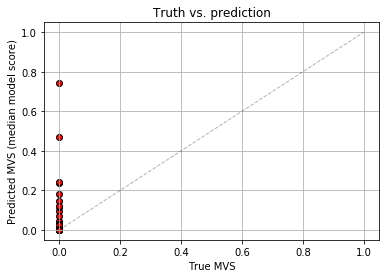

In [18]:
plt.title("Truth vs. prediction")
plt.xlabel('True MVS')
plt.ylabel('Predicted MVS (median model score)')
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.grid(True)
plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='black', alpha=.3)
plt.scatter(df_test['MVS'], df_test['Median model score'], color='r', edgecolor='k');

In [19]:
end = time.time()

print("--> Total processing time = {:.1f} secs".format((end - start)))

--> Total processing time = 465.1 secs


## Conclusion

The supervised non-linear regression algorithms tested in this analysis are able to predict the NBA MVP reasonably well in terms of various regression scores.

**The Top-10 NBA MVP candidates for 2018**, ordered according to the mean scoring rank of all models:

In [20]:
print_nplayers = 10

print("--> Predicted Top-{} MVP candidates {} :".format(print_nplayers, test_year))
print("")

for index, row in df_mvp.iterrows():
    if (index <= print_nplayers):
        #print("{:2}) {:24} ({}) Median MVS Score: {:5.3f} (Actual MVS = {:4.3f}, Games played: {})".format(
        #    index, row['Player'], row['Tm'], row['Median model score'], row['MVS'], row['G']))
        print("{:2}) {:24} ({}) Mean MVS Rank: {:4.1f} (Actual MVS = {:4.3f}, Games played: {})".format(
            index, row['Player'], row['Tm'], row['Mean model rank'], row['MVS'], row['G']))

--> Predicted Top-10 MVP candidates 2018 :

 1) James Harden             (HOU) Mean MVS Rank:  1.0 (Actual MVS = 0.000, Games played: 72)
 2) LeBron James             (CLE) Mean MVS Rank:  2.0 (Actual MVS = 0.000, Games played: 82)
 3) Russell Westbrook        (OKC) Mean MVS Rank:  4.2 (Actual MVS = 0.000, Games played: 80)
 4) Kevin Durant             (GSW) Mean MVS Rank:  4.4 (Actual MVS = 0.000, Games played: 68)
 5) Anthony Davis            (NOP) Mean MVS Rank:  5.6 (Actual MVS = 0.000, Games played: 75)
 6) Giannis Antetokounmpo    (MIL) Mean MVS Rank:  6.2 (Actual MVS = 0.000, Games played: 75)
 7) Damian Lillard           (POR) Mean MVS Rank:  7.2 (Actual MVS = 0.000, Games played: 73)
 8) Kyrie Irving             (BOS) Mean MVS Rank:  9.1 (Actual MVS = 0.000, Games played: 60)
 9) Nikola Jokic             (DEN) Mean MVS Rank: 11.2 (Actual MVS = 0.000, Games played: 75)
10) LaMarcus Aldridge        (SAS) Mean MVS Rank: 12.6 (Actual MVS = 0.000, Games played: 75)
